# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [121]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

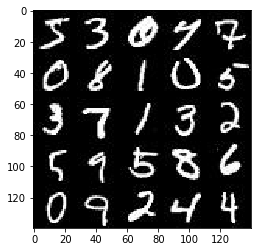

In [122]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

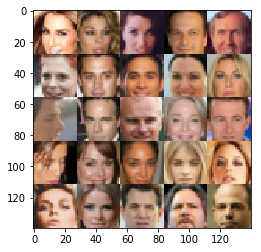

In [123]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [124]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/JasonX/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [125]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [126]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units = 128
    alpha = 0.01

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        # x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        # x3 = tf.layers.batch_normalization(x3, training=True)
        # x3 = tf.maximum(alpha*x3, x3)
        
        # flat = tf.contrib.layers.flatten(x3)
        flat = tf.contrib.layers.flatten(x2)
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [127]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    # print(z.get_shape())
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        # print(x1.get_shape())
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # print(x2.get_shape())
        
        # output layer should be 28x28x3
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # print(logits.get_shape())
        
        out = tf.tanh(logits)
        # print(out.get_shape())
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [128]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # debug
    # print(g_model.get_shape())
    # print(d_model_real.get_shape())
    # print(d_model_fake.get_shape())

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [129]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [130]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [131]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)
print(type(mnist_dataset.shape))

(60000, 28, 28, 1)
<class 'tuple'>


In [132]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    steps = 0
    n_images = 25
    
    print("data_shape = {}".format(data_shape))
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, inputs_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Steps {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
    
    return None 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape = (60000, 28, 28, 1)
Epoch 1/2... Steps 10 Discriminator Loss: 2.8815... Generator Loss: 0.1105
Epoch 1/2... Steps 20 Discriminator Loss: 2.6679... Generator Loss: 0.1572
Epoch 1/2... Steps 30 Discriminator Loss: 0.9217... Generator Loss: 1.5788
Epoch 1/2... Steps 40 Discriminator Loss: 1.5349... Generator Loss: 2.4570
Epoch 1/2... Steps 50 Discriminator Loss: 0.8581... Generator Loss: 1.6803
Epoch 1/2... Steps 60 Discriminator Loss: 1.1155... Generator Loss: 2.2462
Epoch 1/2... Steps 70 Discriminator Loss: 0.5869... Generator Loss: 1.4535
Epoch 1/2... Steps 80 Discriminator Loss: 0.5079... Generator Loss: 1.4093
Epoch 1/2... Steps 90 Discriminator Loss: 0.6866... Generator Loss: 0.9088


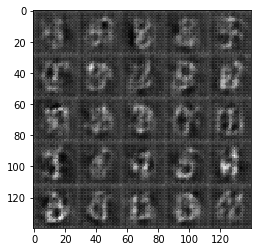

Epoch 1/2... Steps 100 Discriminator Loss: 0.9793... Generator Loss: 0.5597
Epoch 1/2... Steps 110 Discriminator Loss: 0.1673... Generator Loss: 2.4492
Epoch 1/2... Steps 120 Discriminator Loss: 0.0896... Generator Loss: 3.1377
Epoch 1/2... Steps 130 Discriminator Loss: 0.1254... Generator Loss: 2.4860
Epoch 1/2... Steps 140 Discriminator Loss: 2.8280... Generator Loss: 0.0769
Epoch 1/2... Steps 150 Discriminator Loss: 0.7802... Generator Loss: 0.8158
Epoch 1/2... Steps 160 Discriminator Loss: 0.5293... Generator Loss: 1.1328
Epoch 1/2... Steps 170 Discriminator Loss: 2.8825... Generator Loss: 4.7250
Epoch 1/2... Steps 180 Discriminator Loss: 1.1812... Generator Loss: 2.7191
Epoch 1/2... Steps 190 Discriminator Loss: 0.0970... Generator Loss: 3.1942


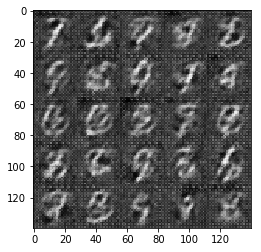

Epoch 1/2... Steps 200 Discriminator Loss: 0.0993... Generator Loss: 4.0620
Epoch 1/2... Steps 210 Discriminator Loss: 0.0621... Generator Loss: 3.4603
Epoch 1/2... Steps 220 Discriminator Loss: 0.1221... Generator Loss: 3.1273
Epoch 1/2... Steps 230 Discriminator Loss: 0.1357... Generator Loss: 5.4184
Epoch 1/2... Steps 240 Discriminator Loss: 1.0450... Generator Loss: 5.6244
Epoch 1/2... Steps 250 Discriminator Loss: 0.2047... Generator Loss: 2.5913
Epoch 1/2... Steps 260 Discriminator Loss: 0.2222... Generator Loss: 3.5022
Epoch 1/2... Steps 270 Discriminator Loss: 0.1369... Generator Loss: 3.2271
Epoch 1/2... Steps 280 Discriminator Loss: 0.7040... Generator Loss: 1.4612
Epoch 1/2... Steps 290 Discriminator Loss: 0.3240... Generator Loss: 3.2627


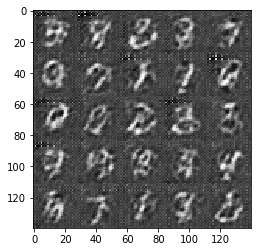

Epoch 1/2... Steps 300 Discriminator Loss: 0.1167... Generator Loss: 4.0494
Epoch 1/2... Steps 310 Discriminator Loss: 0.2683... Generator Loss: 2.0842
Epoch 1/2... Steps 320 Discriminator Loss: 0.0813... Generator Loss: 3.7445
Epoch 1/2... Steps 330 Discriminator Loss: 0.0964... Generator Loss: 5.2143
Epoch 1/2... Steps 340 Discriminator Loss: 0.6540... Generator Loss: 2.2316
Epoch 1/2... Steps 350 Discriminator Loss: 0.5647... Generator Loss: 1.4040
Epoch 1/2... Steps 360 Discriminator Loss: 0.5421... Generator Loss: 1.2517
Epoch 1/2... Steps 370 Discriminator Loss: 0.4826... Generator Loss: 1.4873
Epoch 1/2... Steps 380 Discriminator Loss: 0.2670... Generator Loss: 2.3785
Epoch 1/2... Steps 390 Discriminator Loss: 0.8472... Generator Loss: 0.8019


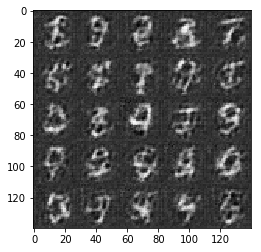

Epoch 1/2... Steps 400 Discriminator Loss: 0.7799... Generator Loss: 1.4342
Epoch 1/2... Steps 410 Discriminator Loss: 0.7550... Generator Loss: 1.0165
Epoch 1/2... Steps 420 Discriminator Loss: 0.3887... Generator Loss: 1.4708
Epoch 1/2... Steps 430 Discriminator Loss: 0.5380... Generator Loss: 2.9411
Epoch 1/2... Steps 440 Discriminator Loss: 0.1632... Generator Loss: 2.8415
Epoch 1/2... Steps 450 Discriminator Loss: 0.1831... Generator Loss: 4.0203
Epoch 1/2... Steps 460 Discriminator Loss: 0.1688... Generator Loss: 2.7636
Epoch 2/2... Steps 470 Discriminator Loss: 0.1477... Generator Loss: 2.7605
Epoch 2/2... Steps 480 Discriminator Loss: 0.1035... Generator Loss: 3.2514
Epoch 2/2... Steps 490 Discriminator Loss: 0.0787... Generator Loss: 3.7899


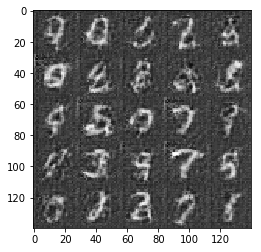

Epoch 2/2... Steps 500 Discriminator Loss: 0.1030... Generator Loss: 3.1431
Epoch 2/2... Steps 510 Discriminator Loss: 0.5549... Generator Loss: 1.4168
Epoch 2/2... Steps 520 Discriminator Loss: 0.1326... Generator Loss: 2.8937
Epoch 2/2... Steps 530 Discriminator Loss: 0.1222... Generator Loss: 2.9567
Epoch 2/2... Steps 540 Discriminator Loss: 0.0890... Generator Loss: 3.2901
Epoch 2/2... Steps 550 Discriminator Loss: 0.1226... Generator Loss: 2.7085
Epoch 2/2... Steps 560 Discriminator Loss: 0.0724... Generator Loss: 3.6852
Epoch 2/2... Steps 570 Discriminator Loss: 0.2104... Generator Loss: 2.1136
Epoch 2/2... Steps 580 Discriminator Loss: 0.1423... Generator Loss: 2.6000
Epoch 2/2... Steps 590 Discriminator Loss: 0.1279... Generator Loss: 2.8683


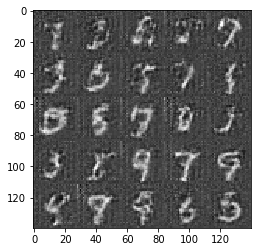

Epoch 2/2... Steps 600 Discriminator Loss: 1.0982... Generator Loss: 2.4857
Epoch 2/2... Steps 610 Discriminator Loss: 0.7047... Generator Loss: 1.2235
Epoch 2/2... Steps 620 Discriminator Loss: 0.4255... Generator Loss: 1.7271
Epoch 2/2... Steps 630 Discriminator Loss: 1.2544... Generator Loss: 3.4467
Epoch 2/2... Steps 640 Discriminator Loss: 0.6210... Generator Loss: 1.0584
Epoch 2/2... Steps 650 Discriminator Loss: 0.6350... Generator Loss: 1.0901
Epoch 2/2... Steps 660 Discriminator Loss: 0.6085... Generator Loss: 1.0621
Epoch 2/2... Steps 670 Discriminator Loss: 0.2063... Generator Loss: 2.9053
Epoch 2/2... Steps 680 Discriminator Loss: 0.2058... Generator Loss: 2.2001
Epoch 2/2... Steps 690 Discriminator Loss: 0.1763... Generator Loss: 2.5559


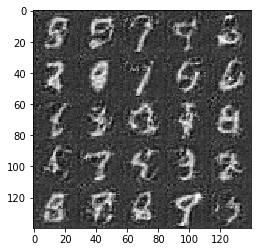

Epoch 2/2... Steps 700 Discriminator Loss: 1.5130... Generator Loss: 2.8852
Epoch 2/2... Steps 710 Discriminator Loss: 0.5148... Generator Loss: 1.3078
Epoch 2/2... Steps 720 Discriminator Loss: 0.4922... Generator Loss: 1.3072
Epoch 2/2... Steps 730 Discriminator Loss: 0.3059... Generator Loss: 2.0280
Epoch 2/2... Steps 740 Discriminator Loss: 0.3312... Generator Loss: 1.6641
Epoch 2/2... Steps 750 Discriminator Loss: 0.1375... Generator Loss: 3.3874
Epoch 2/2... Steps 760 Discriminator Loss: 0.1697... Generator Loss: 2.5882
Epoch 2/2... Steps 770 Discriminator Loss: 0.0564... Generator Loss: 5.1050
Epoch 2/2... Steps 780 Discriminator Loss: 0.0793... Generator Loss: 4.9299
Epoch 2/2... Steps 790 Discriminator Loss: 0.1211... Generator Loss: 3.1499


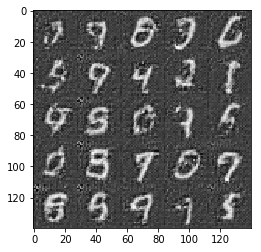

Epoch 2/2... Steps 800 Discriminator Loss: 0.0384... Generator Loss: 6.5863
Epoch 2/2... Steps 810 Discriminator Loss: 0.1723... Generator Loss: 2.4861
Epoch 2/2... Steps 820 Discriminator Loss: 0.0228... Generator Loss: 6.4945
Epoch 2/2... Steps 830 Discriminator Loss: 0.1033... Generator Loss: 3.7951
Epoch 2/2... Steps 840 Discriminator Loss: 0.0354... Generator Loss: 4.8042
Epoch 2/2... Steps 850 Discriminator Loss: 0.1890... Generator Loss: 2.2616
Epoch 2/2... Steps 860 Discriminator Loss: 0.0851... Generator Loss: 3.5343
Epoch 2/2... Steps 870 Discriminator Loss: 0.1403... Generator Loss: 4.1371
Epoch 2/2... Steps 880 Discriminator Loss: 0.1429... Generator Loss: 2.7728
Epoch 2/2... Steps 890 Discriminator Loss: 8.1044... Generator Loss: 9.0369


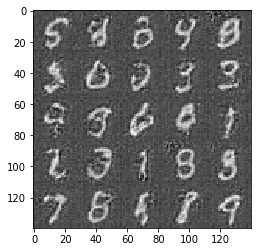

Epoch 2/2... Steps 900 Discriminator Loss: 0.6267... Generator Loss: 2.2011
Epoch 2/2... Steps 910 Discriminator Loss: 0.6256... Generator Loss: 1.2288
Epoch 2/2... Steps 920 Discriminator Loss: 1.3563... Generator Loss: 3.6544
Epoch 2/2... Steps 930 Discriminator Loss: 0.6956... Generator Loss: 1.6605


In [133]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape = (202599, 28, 28, 3)
Epoch 1/1... Steps 10 Discriminator Loss: 1.1005... Generator Loss: 0.6472
Epoch 1/1... Steps 20 Discriminator Loss: 1.8892... Generator Loss: 13.0003
Epoch 1/1... Steps 30 Discriminator Loss: 0.5727... Generator Loss: 1.1344
Epoch 1/1... Steps 40 Discriminator Loss: 0.2632... Generator Loss: 3.6932
Epoch 1/1... Steps 50 Discriminator Loss: 0.1544... Generator Loss: 3.8650
Epoch 1/1... Steps 60 Discriminator Loss: 3.3747... Generator Loss: 8.7659
Epoch 1/1... Steps 70 Discriminator Loss: 0.1544... Generator Loss: 2.7380
Epoch 1/1... Steps 80 Discriminator Loss: 0.0755... Generator Loss: 5.9443
Epoch 1/1... Steps 90 Discriminator Loss: 0.7438... Generator Loss: 1.4822


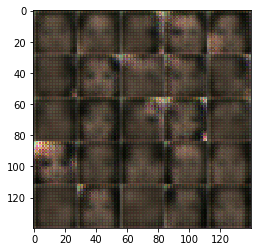

Epoch 1/1... Steps 100 Discriminator Loss: 0.0447... Generator Loss: 5.4069
Epoch 1/1... Steps 110 Discriminator Loss: 0.2088... Generator Loss: 6.0004
Epoch 1/1... Steps 120 Discriminator Loss: 0.1043... Generator Loss: 3.8686
Epoch 1/1... Steps 130 Discriminator Loss: 0.0519... Generator Loss: 4.8230
Epoch 1/1... Steps 140 Discriminator Loss: 0.3358... Generator Loss: 1.6807
Epoch 1/1... Steps 150 Discriminator Loss: 2.2702... Generator Loss: 4.6621
Epoch 1/1... Steps 160 Discriminator Loss: 0.1836... Generator Loss: 5.5558
Epoch 1/1... Steps 170 Discriminator Loss: 0.0978... Generator Loss: 5.4923
Epoch 1/1... Steps 180 Discriminator Loss: 1.8488... Generator Loss: 0.2674
Epoch 1/1... Steps 190 Discriminator Loss: 0.2470... Generator Loss: 3.0488


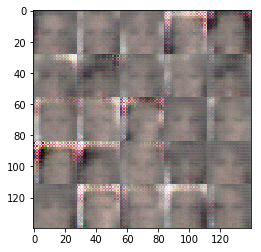

Epoch 1/1... Steps 200 Discriminator Loss: 0.0578... Generator Loss: 5.7383
Epoch 1/1... Steps 210 Discriminator Loss: 0.1776... Generator Loss: 2.4179
Epoch 1/1... Steps 220 Discriminator Loss: 0.1291... Generator Loss: 2.9266
Epoch 1/1... Steps 230 Discriminator Loss: 0.1411... Generator Loss: 4.5811
Epoch 1/1... Steps 240 Discriminator Loss: 0.6381... Generator Loss: 1.4923
Epoch 1/1... Steps 250 Discriminator Loss: 0.2399... Generator Loss: 2.2702
Epoch 1/1... Steps 260 Discriminator Loss: 0.5867... Generator Loss: 1.2549
Epoch 1/1... Steps 270 Discriminator Loss: 0.8760... Generator Loss: 1.4866
Epoch 1/1... Steps 280 Discriminator Loss: 0.1656... Generator Loss: 6.3721
Epoch 1/1... Steps 290 Discriminator Loss: 1.1678... Generator Loss: 0.6648


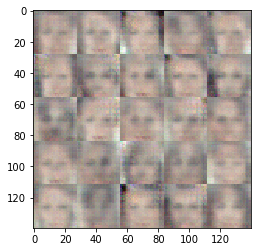

Epoch 1/1... Steps 300 Discriminator Loss: 1.1551... Generator Loss: 0.8031
Epoch 1/1... Steps 310 Discriminator Loss: 0.7986... Generator Loss: 1.1597
Epoch 1/1... Steps 320 Discriminator Loss: 0.8832... Generator Loss: 0.8080
Epoch 1/1... Steps 330 Discriminator Loss: 1.5076... Generator Loss: 0.5384
Epoch 1/1... Steps 340 Discriminator Loss: 1.2067... Generator Loss: 0.7809
Epoch 1/1... Steps 350 Discriminator Loss: 1.2357... Generator Loss: 0.6223
Epoch 1/1... Steps 360 Discriminator Loss: 1.1308... Generator Loss: 0.6848
Epoch 1/1... Steps 370 Discriminator Loss: 1.2458... Generator Loss: 1.0648
Epoch 1/1... Steps 380 Discriminator Loss: 1.1085... Generator Loss: 0.7762
Epoch 1/1... Steps 390 Discriminator Loss: 1.2853... Generator Loss: 0.9711


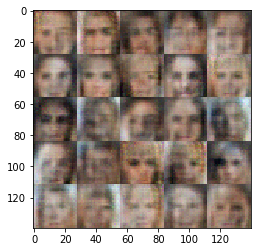

Epoch 1/1... Steps 400 Discriminator Loss: 1.1924... Generator Loss: 0.5579
Epoch 1/1... Steps 410 Discriminator Loss: 1.2238... Generator Loss: 0.8565
Epoch 1/1... Steps 420 Discriminator Loss: 1.2939... Generator Loss: 0.7747
Epoch 1/1... Steps 430 Discriminator Loss: 0.4063... Generator Loss: 11.0731
Epoch 1/1... Steps 440 Discriminator Loss: 1.4585... Generator Loss: 0.9246
Epoch 1/1... Steps 450 Discriminator Loss: 1.4801... Generator Loss: 1.2124
Epoch 1/1... Steps 460 Discriminator Loss: 1.2726... Generator Loss: 0.9470
Epoch 1/1... Steps 470 Discriminator Loss: 1.3181... Generator Loss: 0.6545
Epoch 1/1... Steps 480 Discriminator Loss: 1.3984... Generator Loss: 0.5679
Epoch 1/1... Steps 490 Discriminator Loss: 1.1317... Generator Loss: 0.6338


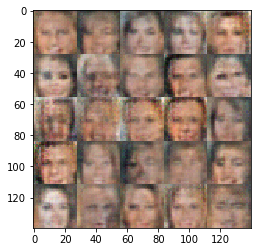

Epoch 1/1... Steps 500 Discriminator Loss: 1.2077... Generator Loss: 0.5762
Epoch 1/1... Steps 510 Discriminator Loss: 1.4073... Generator Loss: 0.5496
Epoch 1/1... Steps 520 Discriminator Loss: 1.3019... Generator Loss: 0.5658
Epoch 1/1... Steps 530 Discriminator Loss: 1.4044... Generator Loss: 0.7543
Epoch 1/1... Steps 540 Discriminator Loss: 1.4316... Generator Loss: 0.4797
Epoch 1/1... Steps 550 Discriminator Loss: 1.3171... Generator Loss: 0.6607
Epoch 1/1... Steps 560 Discriminator Loss: 1.3509... Generator Loss: 0.5309
Epoch 1/1... Steps 570 Discriminator Loss: 1.4052... Generator Loss: 0.6130
Epoch 1/1... Steps 580 Discriminator Loss: 1.4108... Generator Loss: 0.7483
Epoch 1/1... Steps 590 Discriminator Loss: 1.5403... Generator Loss: 0.3811


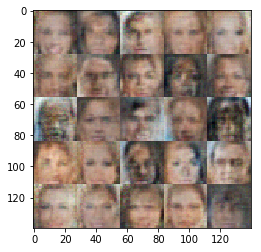

Epoch 1/1... Steps 600 Discriminator Loss: 1.4013... Generator Loss: 0.4109
Epoch 1/1... Steps 610 Discriminator Loss: 1.3122... Generator Loss: 0.7396
Epoch 1/1... Steps 620 Discriminator Loss: 1.3036... Generator Loss: 0.6788
Epoch 1/1... Steps 630 Discriminator Loss: 1.3849... Generator Loss: 0.7613
Epoch 1/1... Steps 640 Discriminator Loss: 1.2494... Generator Loss: 0.6217
Epoch 1/1... Steps 650 Discriminator Loss: 1.2671... Generator Loss: 0.8473
Epoch 1/1... Steps 660 Discriminator Loss: 1.5333... Generator Loss: 0.8634
Epoch 1/1... Steps 670 Discriminator Loss: 1.4647... Generator Loss: 0.6184
Epoch 1/1... Steps 680 Discriminator Loss: 1.4298... Generator Loss: 0.7433
Epoch 1/1... Steps 690 Discriminator Loss: 1.5016... Generator Loss: 0.3202


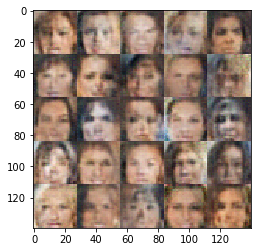

Epoch 1/1... Steps 700 Discriminator Loss: 1.2197... Generator Loss: 0.7125
Epoch 1/1... Steps 710 Discriminator Loss: 1.2555... Generator Loss: 0.6125
Epoch 1/1... Steps 720 Discriminator Loss: 1.5115... Generator Loss: 0.6687
Epoch 1/1... Steps 730 Discriminator Loss: 1.3751... Generator Loss: 0.6269
Epoch 1/1... Steps 740 Discriminator Loss: 1.3176... Generator Loss: 0.6659
Epoch 1/1... Steps 750 Discriminator Loss: 1.4314... Generator Loss: 0.4558
Epoch 1/1... Steps 760 Discriminator Loss: 1.3226... Generator Loss: 0.6979
Epoch 1/1... Steps 770 Discriminator Loss: 1.3839... Generator Loss: 0.5355
Epoch 1/1... Steps 780 Discriminator Loss: 1.2835... Generator Loss: 0.7197
Epoch 1/1... Steps 790 Discriminator Loss: 1.4317... Generator Loss: 0.4277


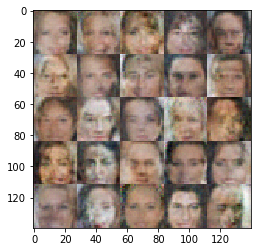

Epoch 1/1... Steps 800 Discriminator Loss: 1.5031... Generator Loss: 0.4661
Epoch 1/1... Steps 810 Discriminator Loss: 1.4471... Generator Loss: 0.8119
Epoch 1/1... Steps 820 Discriminator Loss: 1.1082... Generator Loss: 0.8228
Epoch 1/1... Steps 830 Discriminator Loss: 1.4450... Generator Loss: 0.8675
Epoch 1/1... Steps 840 Discriminator Loss: 1.4654... Generator Loss: 0.6763
Epoch 1/1... Steps 850 Discriminator Loss: 1.3367... Generator Loss: 0.7395
Epoch 1/1... Steps 860 Discriminator Loss: 1.3426... Generator Loss: 0.7347
Epoch 1/1... Steps 870 Discriminator Loss: 1.4964... Generator Loss: 0.6454
Epoch 1/1... Steps 880 Discriminator Loss: 1.8854... Generator Loss: 1.4059
Epoch 1/1... Steps 890 Discriminator Loss: 1.3270... Generator Loss: 0.7295


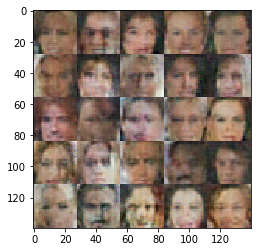

Epoch 1/1... Steps 900 Discriminator Loss: 1.5618... Generator Loss: 1.0459
Epoch 1/1... Steps 910 Discriminator Loss: 1.2966... Generator Loss: 0.6722
Epoch 1/1... Steps 920 Discriminator Loss: 1.2648... Generator Loss: 0.7617
Epoch 1/1... Steps 930 Discriminator Loss: 1.3556... Generator Loss: 0.4626
Epoch 1/1... Steps 940 Discriminator Loss: 1.3860... Generator Loss: 0.6406
Epoch 1/1... Steps 950 Discriminator Loss: 1.3244... Generator Loss: 0.6592
Epoch 1/1... Steps 960 Discriminator Loss: 1.6539... Generator Loss: 1.0438
Epoch 1/1... Steps 970 Discriminator Loss: 1.5218... Generator Loss: 0.7718
Epoch 1/1... Steps 980 Discriminator Loss: 1.3012... Generator Loss: 0.7619
Epoch 1/1... Steps 990 Discriminator Loss: 1.0463... Generator Loss: 9.0712


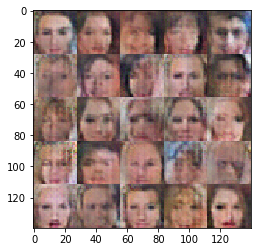

Epoch 1/1... Steps 1000 Discriminator Loss: 1.1685... Generator Loss: 0.6093
Epoch 1/1... Steps 1010 Discriminator Loss: 1.2188... Generator Loss: 0.7539
Epoch 1/1... Steps 1020 Discriminator Loss: 1.5648... Generator Loss: 0.4665
Epoch 1/1... Steps 1030 Discriminator Loss: 1.5566... Generator Loss: 0.4399
Epoch 1/1... Steps 1040 Discriminator Loss: 1.2425... Generator Loss: 0.6560
Epoch 1/1... Steps 1050 Discriminator Loss: 1.2781... Generator Loss: 0.7112
Epoch 1/1... Steps 1060 Discriminator Loss: 1.3492... Generator Loss: 0.7178
Epoch 1/1... Steps 1070 Discriminator Loss: 1.3024... Generator Loss: 0.5824
Epoch 1/1... Steps 1080 Discriminator Loss: 1.3909... Generator Loss: 0.4723
Epoch 1/1... Steps 1090 Discriminator Loss: 1.4080... Generator Loss: 0.5903


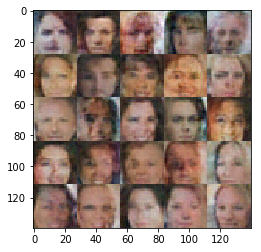

Epoch 1/1... Steps 1100 Discriminator Loss: 1.3110... Generator Loss: 0.6022
Epoch 1/1... Steps 1110 Discriminator Loss: 1.2891... Generator Loss: 0.5567
Epoch 1/1... Steps 1120 Discriminator Loss: 1.3814... Generator Loss: 0.7884
Epoch 1/1... Steps 1130 Discriminator Loss: 1.5259... Generator Loss: 0.8709
Epoch 1/1... Steps 1140 Discriminator Loss: 2.1918... Generator Loss: 1.0733
Epoch 1/1... Steps 1150 Discriminator Loss: 1.6191... Generator Loss: 0.3536
Epoch 1/1... Steps 1160 Discriminator Loss: 1.3469... Generator Loss: 0.6723
Epoch 1/1... Steps 1170 Discriminator Loss: 1.2005... Generator Loss: 0.6647
Epoch 1/1... Steps 1180 Discriminator Loss: 1.1912... Generator Loss: 0.8367
Epoch 1/1... Steps 1190 Discriminator Loss: 1.5250... Generator Loss: 0.3803


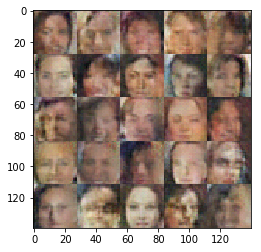

Epoch 1/1... Steps 1200 Discriminator Loss: 1.2149... Generator Loss: 0.7006
Epoch 1/1... Steps 1210 Discriminator Loss: 1.3782... Generator Loss: 0.7582
Epoch 1/1... Steps 1220 Discriminator Loss: 1.2643... Generator Loss: 0.6172
Epoch 1/1... Steps 1230 Discriminator Loss: 1.2043... Generator Loss: 0.6237
Epoch 1/1... Steps 1240 Discriminator Loss: 1.2046... Generator Loss: 0.6799
Epoch 1/1... Steps 1250 Discriminator Loss: 1.2997... Generator Loss: 0.4831
Epoch 1/1... Steps 1260 Discriminator Loss: 1.2424... Generator Loss: 0.8967
Epoch 1/1... Steps 1270 Discriminator Loss: 1.3409... Generator Loss: 0.7191
Epoch 1/1... Steps 1280 Discriminator Loss: 1.3810... Generator Loss: 0.6627
Epoch 1/1... Steps 1290 Discriminator Loss: 1.3379... Generator Loss: 0.8488


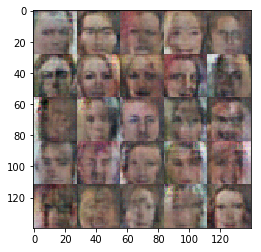

Epoch 1/1... Steps 1300 Discriminator Loss: 11.5003... Generator Loss: 3.6594
Epoch 1/1... Steps 1310 Discriminator Loss: 2.5896... Generator Loss: 0.1260
Epoch 1/1... Steps 1320 Discriminator Loss: 1.2256... Generator Loss: 0.6649
Epoch 1/1... Steps 1330 Discriminator Loss: 1.4722... Generator Loss: 0.8264
Epoch 1/1... Steps 1340 Discriminator Loss: 1.3136... Generator Loss: 0.6524
Epoch 1/1... Steps 1350 Discriminator Loss: 1.1804... Generator Loss: 0.6237
Epoch 1/1... Steps 1360 Discriminator Loss: 1.2435... Generator Loss: 0.5386
Epoch 1/1... Steps 1370 Discriminator Loss: 1.3392... Generator Loss: 0.6344
Epoch 1/1... Steps 1380 Discriminator Loss: 1.4201... Generator Loss: 0.6194
Epoch 1/1... Steps 1390 Discriminator Loss: 1.3791... Generator Loss: 0.7431


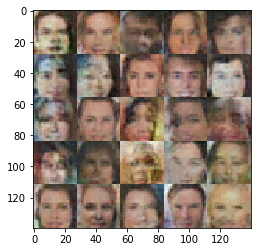

Epoch 1/1... Steps 1400 Discriminator Loss: 1.4638... Generator Loss: 0.6606
Epoch 1/1... Steps 1410 Discriminator Loss: 1.4255... Generator Loss: 0.5546
Epoch 1/1... Steps 1420 Discriminator Loss: 1.4721... Generator Loss: 0.4925
Epoch 1/1... Steps 1430 Discriminator Loss: 1.2190... Generator Loss: 0.5889
Epoch 1/1... Steps 1440 Discriminator Loss: 1.3207... Generator Loss: 0.7063
Epoch 1/1... Steps 1450 Discriminator Loss: 1.3442... Generator Loss: 0.7134
Epoch 1/1... Steps 1460 Discriminator Loss: 1.5403... Generator Loss: 0.4309
Epoch 1/1... Steps 1470 Discriminator Loss: 0.7431... Generator Loss: 1.1236
Epoch 1/1... Steps 1480 Discriminator Loss: 1.6469... Generator Loss: 0.2817
Epoch 1/1... Steps 1490 Discriminator Loss: 1.3963... Generator Loss: 0.7102


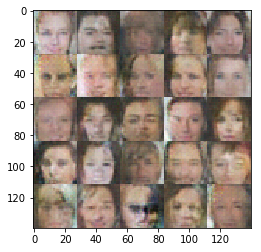

Epoch 1/1... Steps 1500 Discriminator Loss: 1.4540... Generator Loss: 0.4568
Epoch 1/1... Steps 1510 Discriminator Loss: 1.3667... Generator Loss: 0.6320
Epoch 1/1... Steps 1520 Discriminator Loss: 1.3478... Generator Loss: 0.5340
Epoch 1/1... Steps 1530 Discriminator Loss: 1.4450... Generator Loss: 0.4367
Epoch 1/1... Steps 1540 Discriminator Loss: 1.4516... Generator Loss: 0.5223
Epoch 1/1... Steps 1550 Discriminator Loss: 1.3259... Generator Loss: 0.5269
Epoch 1/1... Steps 1560 Discriminator Loss: 1.2753... Generator Loss: 0.6138
Epoch 1/1... Steps 1570 Discriminator Loss: 1.3436... Generator Loss: 0.5231
Epoch 1/1... Steps 1580 Discriminator Loss: 1.3369... Generator Loss: 0.5793


In [134]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.